In [273]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# 1) Importations

In [1]:
%pylab inline
import pandas as pd
import os
import seaborn as sns
from sklearn import preprocessing, manifold, cluster, decomposition, neighbors, model_selection, metrics, linear_model
import scipy as sp
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
def display_progress_bar(n_tot, n_prog) :
    from time import sleep
    progress = math.ceil((n_prog + 1) * 100 / n_tot)
    sys.stdout.write('\r')
    sys.stdout.write("[%-100s] %d%%" %('='*progress, progress))
    sys.stdout.flush()
    sleep(0.25)

# 2) Data loading

In [3]:
# Getting current path
path = os.getcwd()

# Verifying data presence
file_name = "/data/movie_recommendation_reduced_data.csv"
try :
    data = pd.read_csv(path + file_name)
except FileNotFoundError :
    print("Please check if the file %s is at the current location" % file_name)

# 3) Data pre-processing

Having a look at our features : from data processing we expect some numerical variables and some categorical ones followed by genres, actors names and keywords

In [6]:
data.columns.values[:30]

array(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'movie_title', 'num_voted_users', 'num_user_for_reviews',
       'language', 'country', 'title_year', 'imdb_score',
       'movie_facebook_likes', 'Family', 'Action', 'Animation', 'Western',
       'Romance', 'Sport', 'Adventure', 'Comedy', 'War', 'Drama',
       'Mystery', 'Short', 'Fantasy', 'Musical', 'History', 'Horror',
       'Documentary', 'News'], dtype=object)

Definition of our features

In [7]:
categ_feat = ['color', 'director_name', 'movie_title', 'language', 'country']
num_feat = ['num_critic_for_reviews', 'duration', 'num_voted_users', 'num_user_for_reviews',
            'title_year', 'imdb_score', 'movie_facebook_likes']
main_feat = categ_feat + num_feat

Encoding categorical data : OneHot encoding

OneHot encoding decently represent our catagorical features but in return dimensionality tends to explodes : one should use it carefully

In [8]:
# Select categorical variables
categ_df = data.loc[:, categ_feat]
# Select numerical variables
num_df = data.loc[:, num_feat]
# Select manually OneHot pre-encoded variables (genres, keywords, actors)
other_feat = [feat for feat in data.columns.values.tolist() if feat not in main_feat]
other_df = data.loc[:, other_feat]
# Check for missing feature
print("%i missing feature" %(len(data.columns) - len(categ_df.columns) - len(num_df.columns) - len(other_df.columns)))

0 missing feature


In [9]:
# One Hot Encoding categorical variables
categ_df_oh = pd.get_dummies(categ_df)

Standardisation of the numerical data

In [10]:
# Standardisation of the numerical features
std_scaler = preprocessing.StandardScaler()
num_std_arr = std_scaler.fit_transform(num_df)
num_std_df = pd.DataFrame(num_std_arr, index=num_df.index, columns=num_df.columns)

Concatenation to get main dataset

In [11]:
# Concatenate everything for training
movies_df = pd.concat([num_std_df, other_df, categ_df_oh], axis=1)
# Concatenate everything for displaying
movies_df_display = pd.concat([num_df, other_df, categ_df_oh], axis=1)

# 4) Unsupervised exploration

Looking at our data, one could use some dimensionality reduction (thank you OneHot encoding !). Let us have a look at PCA

Look for explained variance ratio >= 95% : SCREE PLOT

In [102]:
def scree_plot(data, data_name, min_comp=2, max_comp=len(data)/100, step_comp=100, update=False) :
    """
    Function to plot and save (or not) scree plots data
    """
    recompute = False
    
    if update :
        recompute = True
    else : 
        try :
            # Scree plot data has already been computed and saved
            result = np.load("data/result_scree_plot_" + data_name + ".npy")
        except FileNotFoundError:
            recompute = True
        
    if recompute :
        # Scree plot data has to be computed and saved
        components = [x for x in range(min_comp, max_comp, step_comp)]
        evrs = []

        for n, num in zip(components, range(1,len(components)+1)) :
            pca = decomposition.PCA(n_components=n)
            pca.fit_transform(data)
            evrs.append(pca.explained_variance_ratio_.sum())
            display_progress_bar(len(components), num)
        # Save curve data
        result = np.array([components, evrs])
        np.save("data/result_scree_plot_" + data_name + ".npy", result)

    # Scree plot
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    plt.plot(result[0], result[1], c='goldenrod')
    ax.set_xlabel("1-specificity")
    ax.set_ylabel("Sensibility")
    
    return result

[======================================================================================================] 102%

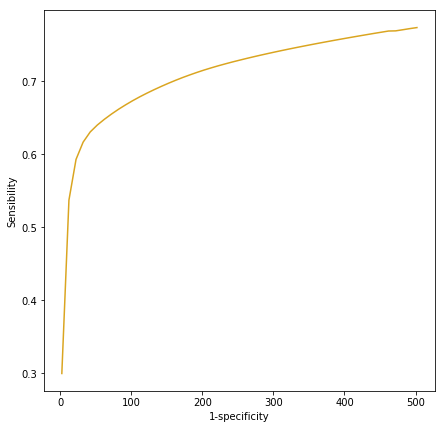

In [230]:
splot = scree_plot(movies_df, 'movies_df_red', 2, 512, 10, update=False)

The plot is interesting : in order to save computational time we might consider using only ~500 components accounting for nearly 80% of the dataset specificity. Otherwise let's try to find how many components would account for 95% of the dataset specificity.

In [104]:
# PCA
pca = decomposition.PCA(n_components=2800)
movies_reduced = pca.fit_transform(movies_df)
print(pca.explained_variance_ratio_.sum())

0.9499848206108561


In [446]:
temp_save = pd.DataFrame(movies_reduced)
temp_save.to_csv("data/reduced_film_tool_data_2800.csv", index=False)

In [12]:
# PCA reduced
pca_150 = decomposition.PCA(n_components=150)
movies_reduced_150 = pca_150.fit_transform(movies_df)
print(pca_150.explained_variance_ratio_.sum())

0.6965221457188743


In [13]:
temp_save = pd.DataFrame(movies_reduced_150)
temp_save.to_csv("data/reduced_film_tool_data_150.csv", index=False)

The 2800 first components account for 95% of the dataset representativity

We've selected the number of components to explain 95% of the data, but this number is still quite high

Just a though, the phenomenon being non linear should we try Kernel PCA ?

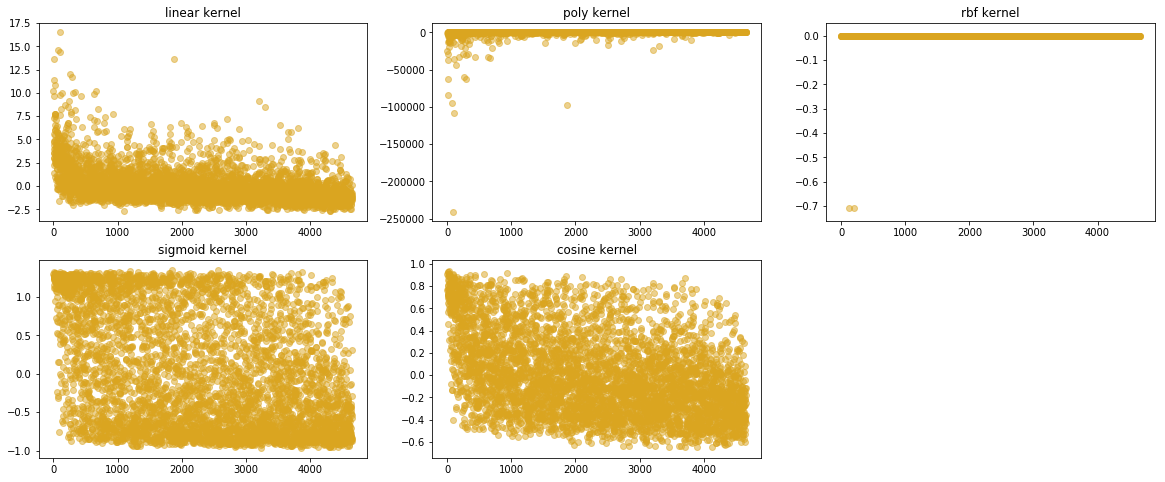

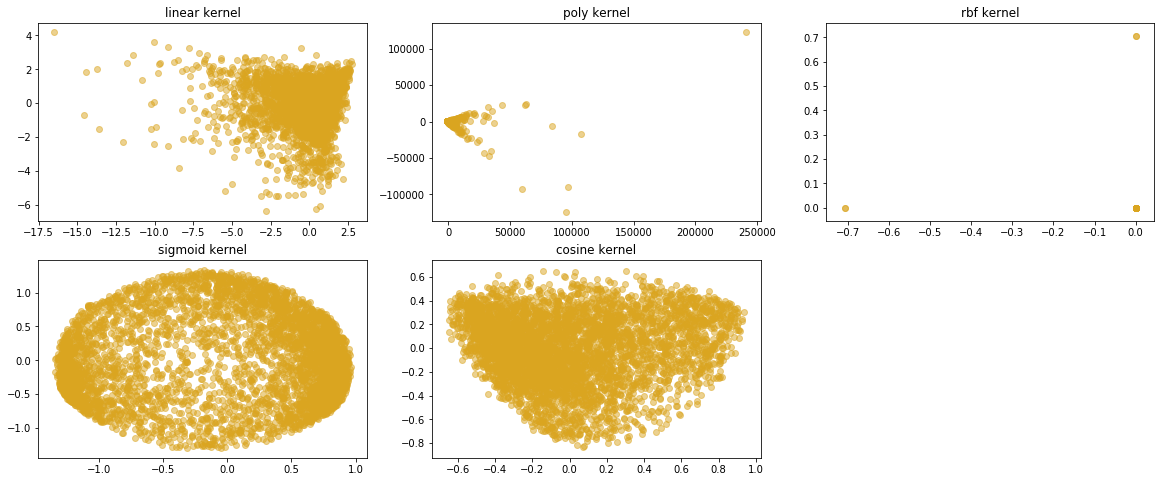

In [106]:
kernels = ["linear", "poly", "rbf", "sigmoid", "cosine", "precomputed"]

# scatter plot 1D for kernels
fig = plt.figure(figsize=(20,8))

for ker, num in zip(kernels, range(1,len(kernels))) :
    kpca = decomposition.KernelPCA(n_components=1, kernel=ker, gamma=10)
    X_spca = kpca.fit_transform(movies_reduced)

    ax = fig.add_subplot(2,3,num)
    ax.scatter(np.arange(0,len(X_spca)), X_spca, c='goldenrod',alpha=0.5)
    ax.set_title("%s kernel" % ker)

# scatter plot 2D for kernels
fig = plt.figure(figsize=(20,8))

for ker, num in zip(kernels, range(1,len(kernels))) :
    kpca = decomposition.KernelPCA(n_components=2, kernel=ker, gamma=10)
    X_spca = kpca.fit_transform(movies_reduced)
    
    ax = fig.add_subplot(2,3,num)
    ax.scatter(X_spca[:,0],X_spca[:,1], c='goldenrod',alpha=0.5)
    ax.set_title("%s kernel" % ker)

Can't easily separate data with kpca, worthed trying though !

Let us observe the 2 main components of the reduced data :

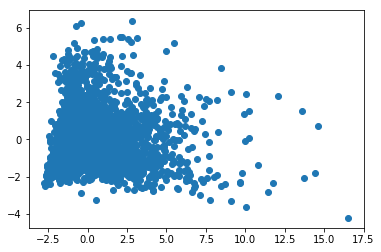

In [107]:
plt.scatter(movies_reduced[:,0], movies_reduced[:,1])

Well this is a big pack of points, there is no easy way to predict if one could perform a clustering on the data, we will try anyway

KMEANS : it has the ability to let the user choose the number of cluster expected. If we would like to produce recommendation we will let at least 10 movies in each cluster.

In [108]:
# Set a KMeans clustering
kmeans = cluster.KMeans(init='k-means++', n_clusters=400, n_init=1)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit(movies_reduced)

What's the visualisation on the first two principal components ?

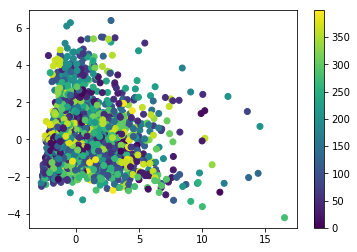

In [109]:
plt.scatter(movies_reduced[:, 0], movies_reduced[:, 1], c=kmeans.labels_)
plt.colorbar()

Well this is poor clustering, let's forget about it

New approach : Nearest Neighbors. Pick a movie, find the closest movies to this reference based on some criterions

In [110]:
# Defining a list of random movies that we will use as comparison references
rand_list = np.random.randint(1, movies_reduced.shape[0]-1, size=10)
print("Movies indeces for Nearest Neighbors algorithms testing : \n", rand_list)

Movies indeces for Nearest Neighbors algorithms testing : 
 [ 122 3941 3025 1893 2605 2328 4381  568 2114 2453]


Final models comparison

In [138]:
def retrieve_one_hot_result_new(categ_ref, df) :
    """
    Function to retrieve the output from one-hot encoded dataframe
    """
    # Retrieve categories names
    categories = categ_ref.columns
    if isinstance(df, pd.core.frame.DataFrame) : # For testing
        out_df = pd.DataFrame()
        # Separate DF in SERIES and apply SERIES function
        for row in df.iterrows() :   
            temp_ser = row[1]
            # Separate float and categorial columns
            num_ref = temp_ser.iloc[:7]
            one_hot_ref = temp_ser.iloc[5972:]
            # Retrieve values of one hot encoding
            one_hot_ref = one_hot_ref[one_hot_ref == 1].dropna()
            # Replace values of categorial df with columns (one hot) names
            new_value = []
            for i in range(len(one_hot_ref.index)) :
                new_value.append(one_hot_ref.index[i].replace(categories[:len(one_hot_ref.index)][i] + "_",""))
            one_hot_ref.loc[:] = new_value
            # Replaces columns names of categorial df with original categories names
            one_hot_ref.index = categories[:len(one_hot_ref.index)]
            # Full serie
            temp_df = pd.concat([num_ref, one_hot_ref])
            out_df = out_df.append(temp_df)

    elif isinstance(df, pd.core.series.Series) :
        # Separate float and categorial columns
        num_ref = df.iloc[:7]
        one_hot_ref = df.iloc[5972:]
        # Retrieve values of one hot encoding
        one_hot_ref = one_hot_ref[one_hot_ref == 1].dropna()
        # Replace values of categorial df with columns (one hot) names
        new_value = []
        for i in range(len(one_hot_ref.index)) :
            new_value.append(one_hot_ref.index[i].replace(categories[:len(one_hot_ref.index)][i] + "_",""))
        one_hot_ref.loc[:] = new_value
        # Replaces columns names of categorial df with original categories names
        one_hot_ref.index = categories[:len(one_hot_ref.index)]
        # Full df
        out_df = pd.concat([num_ref, one_hot_ref])
        
    return out_df

def other_results_new(df) :
    """
    Function to retrieve the output from manually one-hot encoded dataframe
    """
#     out_df = pd.DataFrame(columns=['genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8',
#                                    'kw_1','kw_2','kw_3','kw_4','kw_5','actor_1','actor_2','actor_3'])
    
    if isinstance(df, pd.core.frame.DataFrame) : # For testing
        out_df = pd.DataFrame()
        # Separate DF in SERIES and apply SERIES function
        for row in df.iterrows() :   
            temp_ser = row[1]
    
            # Initialize genres output
            genres_df = pd.DataFrame(columns=['genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8'])
            # Separate genres
            genres_ref = temp_ser.iloc[7:31]
            # Get non missing genres
            resu_df = genres_ref.iloc[genres_ref.nonzero()[0]]
            # Initialize result array
            array_nan = np.full((1,8), '0', dtype='object')
            # Fill result array with found genres
            for i in range(0,len(resu_df.index.values)) :
                array_nan[0][i] = resu_df.index.values[i]
            # Initialize movie output
            temp_res = pd.DataFrame(array_nan, columns=['genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8'])
            # Add movie output to global output
            genres_df = genres_df.append(pd.DataFrame(temp_res))

            # Initialize keywords output
            keywords_df = pd.DataFrame(columns=['kw_1','kw_2','kw_3','kw_4','kw_5'])
            # Separate keywords
            keywords_ref = temp_ser.iloc[31:131]
            # Get non missing keywords
            resu_df = keywords_ref.iloc[keywords_ref.nonzero()[0]]
            # Initialize result array
            array_nan = np.full((1,5), '0', dtype='object')
            # Fill result array with found genres
            for i in range(0,len(resu_df.index.values)) :
                array_nan[0][i] = resu_df.index.values[i]
            # Initialize movie output
            temp_res = pd.DataFrame(array_nan, columns=['kw_1','kw_2','kw_3','kw_4','kw_5'])
            # Add movie output to global output
            keywords_df = keywords_df.append(pd.DataFrame(temp_res))

            # Initialize actors output
            actors_df = pd.DataFrame(columns=['actor_1','actor_2','actor_3'])
            # Separate actors
            actors_ref = temp_ser.iloc[131:5972]
            # Get non missing actors
            resu_df = actors_ref.iloc[actors_ref.nonzero()[0]]
            # Initialize result array
            array_nan = np.full((1,3), '0', dtype='object')
            # Fill result array with found genres
            for i in range(0,len(resu_df.index.values)) :
                array_nan[0][i] = resu_df.index.values[i]
            # Initialize movie output
            temp_res = pd.DataFrame(array_nan, columns=['actor_1','actor_2','actor_3'])
            # Add movie output to global output
            actors_df = actors_df.append(pd.DataFrame(temp_res))
                    
            temp_df = pd.concat([genres_df, keywords_df, actors_df], axis=1, sort=False)
            out_df = out_df.append(temp_df)
        
    elif isinstance(df, pd.core.series.Series) :
        
        # Initialize genres output
        genres_df = pd.DataFrame(columns=['genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8'])
        # Separate genres
        genres_ref = df.iloc[7:31]
        # Get non missing genres
        resu_df = genres_ref.iloc[genres_ref.nonzero()[0]]
        # Initialize result array
        array_nan = np.full((1,8), '0', dtype='object')
        # Fill result array with found genres
        for i in range(0,len(resu_df.index.values)) :
            array_nan[0][i] = resu_df.index.values[i]
        # Initialize movie output
        temp_res = pd.DataFrame(array_nan, columns=['genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8'])
        # Add movie output to global output
        genres_df = genres_df.append(pd.DataFrame(temp_res))

        # Initialize keywords output
        keywords_df = pd.DataFrame(columns=['kw_1','kw_2','kw_3','kw_4','kw_5'])
        # Separate keywords
        keywords_ref = df.iloc[31:131]
        # Get non missing keywords
        resu_df = keywords_ref.iloc[keywords_ref.nonzero()[0]]
        # Initialize result array
        array_nan = np.full((1,5), '0', dtype='object')
        # Fill result array with found genres
        for i in range(0,len(resu_df.index.values)) :
            array_nan[0][i] = resu_df.index.values[i]
        # Initialize movie output
        temp_res = pd.DataFrame(array_nan, columns=['kw_1','kw_2','kw_3','kw_4','kw_5'])
        # Add movie output to global output
        keywords_df = keywords_df.append(pd.DataFrame(temp_res))

        # Initialize actors output
        actors_df = pd.DataFrame(columns=['actor_1','actor_2','actor_3'])
        # Separate actors
        actors_ref = df.iloc[131:5972]
        # Get non missing actors
        resu_df = actors_ref.iloc[actors_ref.nonzero()[0]]
        # Initialize result array
        array_nan = np.full((1,3), '0', dtype='object')
        # Fill result array with found genres
        for i in range(0,len(resu_df.index.values)) :
            array_nan[0][i] = resu_df.index.values[i]
        # Initialize movie output
        temp_res = pd.DataFrame(array_nan, columns=['actor_1','actor_2','actor_3'])
        # Add movie output to global output
        actors_df = actors_df.append(pd.DataFrame(temp_res))

        out_df = pd.concat([genres_df, keywords_df, actors_df], axis=1, sort=False)        
        
    return out_df

Neihbors parameter

In [112]:
neighbs = 10

Models setting : we will compare two distances, euclidean and mahalanobis

In [234]:
# Base data, with normalisation, with PCA reduced to 2800 first components, euclidean distance
nearest_neighbors_euc = neighbors.NearestNeighbors(neighbs)
nearest_neighbors_euc.fit(movies_reduced)
# Base data, with normalisation, with PCA reduced to 150 first components, Mahalanobis distance
V = np.cov(movies_reduced_150)
nearest_neighbors_maha = neighbors.NearestNeighbors(neighbs, algorithm='brute', metric='mahalanobis', metric_params={'V': V})
nearest_neighbors_maha.fit(movies_reduced_150);

Create test dataframe from randomly chosen indeces

In [236]:
# # Random movie pick
# aleat = np.random.randint(0,data.shape[0])
# # Imposed movie pick
# aleat = 52

movie_references_2800 = pd.DataFrame(movies_reduced[rand_list, :])
movie_references_150 = pd.DataFrame(movies_reduced_150[rand_list, :])

Algorithms comparison

In [237]:
# Set algorithms for loop
algorithms_ref = [(nearest_neighbors_euc, movie_references_2800), (nearest_neighbors_maha, movie_references_150)]

# Initialize outputs
results = {}
res_df = pd.DataFrame(columns=movies_df.columns)
algos_df = []

# Run the loop
for algo, movie_refs in algorithms_ref :
    print("Running algorithm : ", algo)    
    list_df = []
    
    for index, ref_movie in movie_refs.iterrows() :
        print("Running algorithm for movie : ", index)    
        # Run the algorithm for the input movie : look for nearest neighbors
        
        res_algo = algo.kneighbors(ref_movie.values.reshape(1, -1))
        results[algo] = res_algo

        # Retrieve results from data
        out_df = pd.DataFrame()    
        for i in range(len(res_algo[1][0])) :
            temp_df = pd.DataFrame()
            temp_df = temp_df.append(retrieve_one_hot_result_new(categ_df, movies_df_display.iloc[res_algo[1][0][i], :]))
            temp_df2 = other_results_new(movies_df_display.iloc[res_algo[1][0][i], :])
            temp_df2.index = temp_df.index
            temp_df3 = pd.concat([temp_df, temp_df2], axis=1, sort=False)
            out_df = out_df.append(temp_df3, ignore_index=False)

            # Clarify input movie status in output DF
        out_df = out_df.rename(index={out_df.index[0]:'input'})
        
        # Save output dataframe for this movie
        list_df.append(out_df)
        
        res_df = pd.concat(list_df, sort=False)
    
    # Save output dataframe for this algorithm
    algos_df.append(res_df)

# Concatenate results into one DF
algo_keys = ['euc', 'maha']
res_df = pd.concat(algos_df, keys=algo_keys, sort=False)

# res_df.to_csv("data/final_algos_comparison.csv")

Running algorithm :  NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)
Running algorithm for movie :  0
Running algorithm for movie :  1
Running algorithm for movie :  2
Running algorithm for movie :  3
Running algorithm for movie :  4
Running algorithm for movie :  5
Running algorithm for movie :  6
Running algorithm for movie :  7
Running algorithm for movie :  8
Running algorithm for movie :  9
Running algorithm :  NearestNeighbors(algorithm='brute', leaf_size=30, metric='mahalanobis',
         metric_params={'V': array([[ 0.84893,  0.34641, ..., -0.11362, -0.09056],
       [ 0.34641,  0.18637, ..., -0.04905, -0.03716],
       ...,
       [-0.11362, -0.04905, ...,  0.06057,  0.01741],
       [-0.09056, -0.03716, ...,  0.01741,  0.02633]])},
         n_jobs=1, n_neighbors=10, p=2, radius=1.0)
Running algorithm for movie :  0
Running algorithm for movie :  1
Running algorithm for movie :  2
Runn

What have we done ?

In [239]:
res_df

color  country         director_name  duration  imdb_score  \
euc  input  Color      USA            Gavin Hood     119.0         6.7   
     174    Color      USA       Louis Leterrier     135.0         6.8   
     41     Color      USA       Martin Campbell     123.0         5.6   
     139    Color      USA           J.J. Abrams     124.0         6.9   
     510    Color      USA     Timur Bekmambetov     110.0         6.7   
     206    Color      USA       Louis Leterrier     106.0         5.8   
     266    Color      USA           Alex Proyas     115.0         7.1   
     419    Color      USA    Guillermo del Toro     120.0         7.0   
     212    Color      USA       Roland Emmerich     124.0         6.4   
     652    Color      USA        David S. Goyer     122.0         5.9   
     input  Color       UK           James Ivory     140.0         7.8   
     3839   Color       UK           James Ivory     117.0         7.4   
     2559   Color       UK           James Ivory     134.0         7.9   
     3240   Color       UK           James Ivory     140.0         7.5   
     2014   Color      USA        Clint Eastwood     135.0         7.5   
     3055   Color       UK        Terence Davies     135.0         7.1   
     2363   Color       UK       Kenneth Branagh     150.0         7.8   
     3650   Color       UK           Mike Newell     117.0         7.1   
     2809   Color       UK      Barbra Streisand     132.0         6.6   
     1950   Color      USA        Stephen Frears     119.0         7.7   
     input  Color  Germany  Michael Patrick Jann      97.0         6.5   
     1989   Color      USA          Tony Goldwyn      97.0         6.1   
     2748   Color   France        Andrew Fleming      94.0         6.1   
     3023   Color      USA         Tommy O'Haver      87.0         5.8   
     1431   Color       UK     Richard Loncraine      98.0         6.3   
     905    Color      USA          Steven Brill      96.0         5.8   
     2943   Color       UK         Oliver Parker      97.0         6.9   
     2309   Color      USA         Mike Mitchell      88.0         5.7   
     1255   Color      USA         Stephen Herek     103.0         5.8   
     2476   Color      USA           Woody Allen     112.0         6.6   
...           ...      ...                   ...       ...         ...   
maha input  Color      USA            Ron Howard     139.0         6.6   
     1655   Color      USA           Brad Furman      88.0         5.6   
     3262   Color      USA        Robert Moresco     107.0         6.4   
     1848   Color      USA  Paul Thomas Anderson     158.0         8.1   
     950    Color      USA           John Landis     104.0         5.5   
     2668   Color      USA            Kevin Bray      95.0         5.7   
     2049   Color      USA      William Friedkin      92.0         7.7   
     2481   Color      USA            James Gray     120.0         6.6   
     2911   Color      USA            Rob Pritts      86.0         4.6   
     3735   Color       UK       Stefan Schwartz      99.0         6.6   
     input  Color      USA       Jason Friedberg      93.0         2.3   
     1468   Color      USA    George Tillman Jr.     128.0         7.1   
     2404   Color      USA          Daniel Barnz      86.0         5.6   
     2936   Color      USA     Agnieszka Holland     104.0         6.8   
     2186   Color      USA       Jason Friedberg      88.0         1.9   
     3472   Color   France       Cédric Klapisch     111.0         7.3   
     2383   Color      USA            Jon M. Chu      98.0         6.2   
     3569   Color      USA        Michael Tiddes      92.0         3.5   
     4388   Color      USA            Ryan Fleck     106.0         7.2   
     2672   Color      USA          David Zucker      90.0         4.6   
     input  Color    Spain    Guillermo del Toro     112.0         8.2   
     4002   Color    Spain       Jaume Balagueró      78.0         7.5   
     3484   Colo

# 5) Exploiting the results euclidean model

Create DF by feature for study

In [249]:
feat_dfs = []
for feat in res_df.columns[:12] :
    euc_df = res_df.copy()
    euc_df.index = euc_df.index.droplevel()
    feat_df = euc_df.loc[:,feat]
    test_df = pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
    for i in range(0,10) :
        test_df.iloc[:,i] = feat_df.iloc[i*10:(i+1)*10].values
    feat_dfs.append([test_df, feat])

Let's look for tendances in our prediction tool

First the numerical and categorical features

color


,0,1,2,3,4,5,6,7,8,9
0,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
1,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
2,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color
3,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
4,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
5,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
6,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color
7,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
8,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
9,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color


country


,0,1,2,3,4,5,6,7,8,9
0,USA,UK,Germany,UK,USA,USA,USA,USA,USA,Spain
1,USA,UK,USA,UK,USA,USA,USA,USA,USA,USA
2,USA,UK,France,UK,USA,USA,USA,USA,USA,USA
3,USA,UK,USA,USA,USA,USA,USA,USA,USA,USA
4,USA,USA,UK,UK,USA,USA,USA,USA,USA,USA
5,USA,UK,USA,USA,USA,USA,USA,USA,USA,USA
6,USA,UK,UK,UK,USA,USA,USA,USA,USA,UK
7,USA,UK,USA,Germany,USA,USA,USA,USA,USA,UK
8,USA,UK,USA,USA,USA,USA,USA,USA,USA,USA
9,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA


director_name


,0,1,2,3,4,5,6,7,8,9
0,Gavin Hood,James Ivory,Michael Patrick Jann,Steve Barron,Tina Gordon Chism,Rick Friedberg,Fred Zinnemann,Ron Howard,Jason Friedberg,Guillermo del Toro
1,Louis Leterrier,James Ivory,Tony Goldwyn,Peter Hewitt,Tim Story,Steve Rash,John Ford,Barry Sonnenfeld,Jason Friedberg,Clint Eastwood
2,Martin Campbell,James Ivory,Andrew Fleming,Jonathan Newman,Donald Petrie,Reginald Hudlin,John Ford,Richard Donner,Jason Friedberg,Mary Harron
3,J.J. Abrams,James Ivory,Tommy O'Haver,John Eng,Phil Traill,Stephen Herek,Billy Wilder,Wolfgang Petersen,Aaron Seltzer,Tim Burton
4,Timur Bekmambetov,Clint Eastwood,Richard Loncraine,Tim Hill,Richard Schenkman,S.R. Bindler,Elia Kazan,Richard Donner,Dennis Dugan,Clint Eastwood
5,Louis Leterrier,Terence Davies,Steven Brill,Ruggero Deodato,Steve Pink,Albert Brooks,Fred Zinnemann,Richard Donner,Michael Tiddes,Alfonso Cuarón
6,Alex Proyas,Kenneth Branagh,Oliver Parker,John Guillermin,Greg Coolidge,Angela Robinson,Mel Brooks,Quentin Tarantino,Perry Andelin Blake,Matthew Vaughn
7,Guillermo del Toro,Mike Newell,Mike Mitchell,Rob Minkoff,David E. Talbert,Malcolm D. Lee,Michael Roemer,James Mangold,Bo Welch,Danny Boyle
8,Roland Emmerich,Barbra Streisand,Stephen Herek,Shawn Levy,Zach Cregger,Cheryl Dunye,Frank Capra,Renny Harlin,Malcolm D. Lee,Kathryn Bigelow
9,David S. Goyer,Stephen Frears,Woody Allen,Brian Levant,Paul Feig,Sam Weisman,Orson Welles,John Woo,Tom Brady,Jonathan Dayton


duration


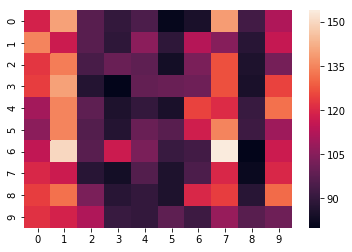

imdb_score


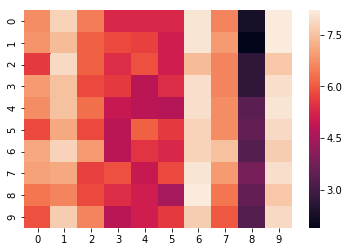

language


,0,1,2,3,4,5,6,7,8,9
0,English,English,English,Italian,English,English,English,English,English,Spanish
1,English,English,English,English,English,English,English,English,English,English
2,English,English,English,English,English,English,English,English,English,English
3,English,English,English,English,English,English,English,English,English,English
4,English,English,English,English,English,English,English,English,English,English
5,English,English,English,English,English,English,English,English,English,English
6,English,English,English,English,English,English,English,English,English,English
7,English,English,English,English,English,English,English,English,English,English
8,English,English,English,English,English,English,English,English,English,English
9,English,English,English,English,English,English,English,English,English,English


movie_facebook_likes


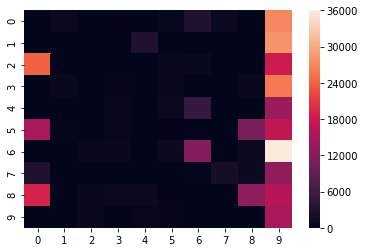

movie_title


,0,1,2,3,4,5,6,7,8,9
0,X-Men Origins: Wolverine,Maurice,Drop Dead Gorgeous,The Adventures of Pinocchio,Peeples,Spy Hard,High Noon,Ransom,Epic Movie,Pan's Labyrinth
1,The Incredible Hulk,A Room with a View,Someone Like You...,The Borrowers,Think Like a Man Too,Held Up,The Man Who Shot Liberty Valance,Get Shorty,Disaster Movie,Gran Torino
2,Green Lantern,The Remains of the Day,Dick,The Adventurer: The Curse of the Midas Box,My Life in Ruins,The Ladies Man,She Wore a Yellow Ribbon,Lethal Weapon 4,Meet the Spartans,American Psycho
3,Mission: Impossible III,Howards End,Get Over It,Rugrats Go Wild,All About Steve,Man of the House,The Lost Weekend,Outbreak,Date Movie,Big Fish
4,Wanted,The Bridges of Madison County,Wimbledon,Garfield 2,And Then Came Love,"Surfer, Dude",A Streetcar Named Desire,Lethal Weapon 3,Jack and Jill,Million Dollar Baby
5,Clash of the Titans,The House of Mirth,Mr. Deeds,The Barbarians,About Last Night,The Muse,From Here to Eternity,Conspiracy Theory,Fifty Shades of Black,Children of Men
6,"I, Robot",Hamlet,An Ideal Husband,Sheena,Employee of the Month,D.E.B.S.,Blazing Saddles,Jackie Brown,The Master of Disguise,Kick-Ass
7,Hellboy II: The Golden Army,Four Weddings and a Funeral,Deuce Bigalow: Male Gigolo,Stuart Little,Baggage Claim,Undercover Brother,Nothing But a Man,Cop Land,The Cat in the Hat,Slumdog Millionaire
8,The Day After Tomorrow,Yentl,Life or Something Like It,Big Fat Liar,Miss March,My Baby's Daddy,Mr. Smith Goes to Washington,Cliffhanger,Scary Movie 5,The Hurt Locker
9,Blade: Trinity,Dangerous Liaisons,Hollywood Ending,The Flintstones,Unaccompanied Minors,Dickie Roberts: Former Child Star,The Lady from Shanghai,Broken Arrow,Bucky Larson: Born to Be a Star,Little Miss Sunshine


num_critic_for_reviews


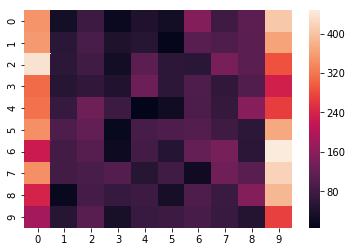

num_user_for_reviews


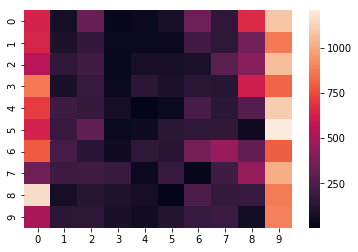

num_voted_users


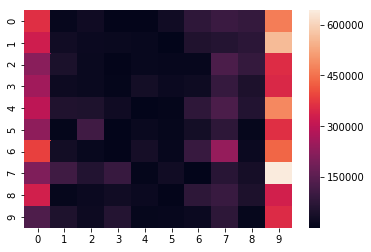

title_year


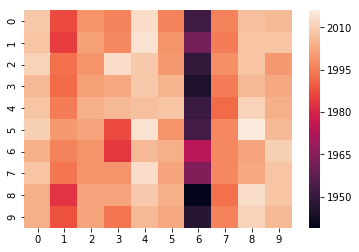

In [260]:
for df, feat in feat_dfs : 
    print(feat)
    if df.dtypes[0] == 'object' :
        display(df)
    else :
        plt.figure()
        sns.heatmap(df)
        plt.show()

About what we've just seen :
- Without saying that's it's a main criteria, the algorithm tends to recommend colored movies for colored movie and same for B&W
- As most of the movies in the database are US movies, we won't be foolish enough to say that country is a criteria or not for our tool, same goes for language
- The director's name on another hand may be a feature of interest for our algorithm as we see movies from the same director for 3 of our test movies
- Heatmap of the duration is most likely evenly distributed, not a main feature then
- IMDB score's heatmap shows pretty close values column-wise, which let us think that it might well be taken into account by the algorithm
- movie facebook likes are mostly 0. The feature might deserve not to be taken into account
- num_critic_for_reviews / num_user_for_reviews / num_voted_users : Those shows similar colorsets column-wise, meaning that they might have been taken into account by the algorithm
- The title year being quite close to one recommendation to another leads to say that this probably a main feature for our algorithm

Then the other features (genres, keywords and actors)

In [290]:
# Select features
features = [[x for x in res_df.columns if x.startswith('actor')]]
features.append([x for x in res_df.columns if x.startswith('genre')])
features.append([x for x in res_df.columns if x.startswith('kw')])

In [276]:
# Gather features in dataframes
feat_others_dfs = []
for feats in features :
    euc_df = res_df.copy()
    euc_df.index = euc_df.index.droplevel()
    feat_df = euc_df.loc[:,feats].apply(lambda x: ','.join(x), axis=1)
    test_df = pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
    for i in range(0,10) :
        test_df.iloc[:,i] = feat_df.iloc[i*10:(i+1)*10].values
    feat_others_dfs.append([test_df, feats])

In [410]:
# Transform values in count of common values to the reference movie
other_dfs = []
for df_other in feat_others_dfs :
    temp_df = pd.DataFrame(np.zeros((10,10)), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
    for i in range(0,10) :
        tp_df = df_other[0][i]
        for j in range(0,10) :
            values = tp_df.iloc[j].split(",")
            value_count = 0
            temp_df.iloc[j,i]
            for value in values :
                if (value != '0') and (value in tp_df.iloc[0].split(",")) :
                    value_count += 1
                    temp_df.iloc[j,i] = value_count
                elif value == '0' :
                    pass
    temp_df = temp_df.astype(int)
    
    other_dfs.append([temp_df, df_other[1]])

['actor_1', 'actor_2', 'actor_3']


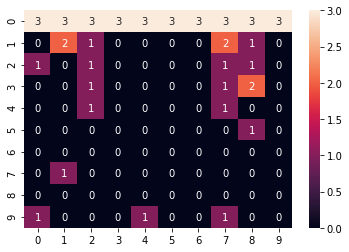

['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8']


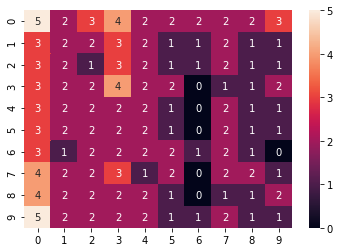

['kw_1', 'kw_2', 'kw_3', 'kw_4', 'kw_5']


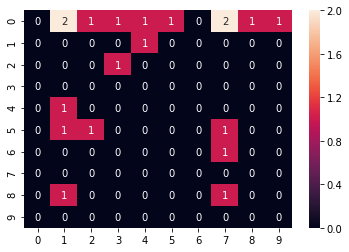

In [411]:
# Display the heatmaps
for df, feats in other_dfs : 
    print(feats)
    plt.figure()
    sns.heatmap(df, annot=True)
    plt.show()

About those 3 last features :
- Except for some test movies, the actors do not seem to be a criteria for the algorithm : too few actors in common between the recommendations and the reference
- Same conclusion goes for the keywords, which are too few to be used properply
- On another hand the genres seem to be well respected by the recommendations, with most often 70% of genres in common. Genres are, directly or inderectly, one of the main criterions of the algorithm

# 6) Exploiting the results : Mahalanobis model

Create DF by feature for study

In [421]:
feat_dfs = []
for feat in res_df.columns[:12] :
    maha_df = res_df.iloc[100:,:].copy()
    maha_df.index = maha_df.index.droplevel()
    feat_df = maha_df.loc[:,feat]
    test_df = pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
    for i in range(0,10) :
        test_df.iloc[:,i] = feat_df.iloc[i*10:(i+1)*10].values
    feat_dfs.append([test_df, feat])

Let's look for tendances in our prediction tool

First the numerical and categorical features

color


,0,1,2,3,4,5,6,7,8,9
0,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
1,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color
2,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color
3,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
4,Color,Color,Color,Color,Color,Color,Black and White,Color,Color,Color
5,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color
6,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color
7,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color
8,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color
9,Color,Color,Color,Color,Color,Color,Color,Color,Color,Color


country


,0,1,2,3,4,5,6,7,8,9
0,USA,UK,Germany,UK,USA,USA,USA,USA,USA,Spain
1,USA,USA,USA,USA,USA,USA,USA,USA,USA,Spain
2,USA,USA,USA,USA,USA,USA,USA,USA,USA,Spain
3,USA,USA,USA,USA,USA,USA,USA,USA,USA,Spain
4,USA,USA,UK,Brazil,USA,USA,USA,USA,USA,USA
5,USA,New Zealand,USA,USA,USA,USA,USA,USA,France,USA
6,USA,USA,USA,USA,USA,USA,USA,USA,USA,Spain
7,USA,USA,USA,USA,USA,USA,USA,USA,USA,Spain
8,USA,South Africa,USA,USA,USA,USA,UK,USA,USA,USA
9,USA,South Africa,USA,USA,USA,USA,USA,UK,USA,USA


director_name


,0,1,2,3,4,5,6,7,8,9
0,Gavin Hood,James Ivory,Michael Patrick Jann,Steve Barron,Tina Gordon Chism,Rick Friedberg,Fred Zinnemann,Ron Howard,Jason Friedberg,Guillermo del Toro
1,James Mangold,Reginald Hudlin,Stephen Hopkins,James Schamus,Steve Carr,Richard Donner,John Ford,Brad Furman,George Tillman Jr.,Jaume Balagueró
2,Tim Story,Mora Stephens,David Cross,Jonathan Parker,John Singleton,Nimród Antal,Mel Brooks,Robert Moresco,Daniel Barnz,Jaume Balagueró
3,Martin Campbell,Qasim Basir,Christopher Guest,Cyrus Nowrasteh,John Sayles,Newt Arnold,Jack Conway,Paul Thomas Anderson,Agnieszka Holland,Nacho Vigalondo
4,D.J. Caruso,Jeff Crook,Jamie Thraves,Bruno Barreto,Malcolm D. Lee,James McTeigue,John Ford,John Landis,Jason Friedberg,Andrew Adamson
5,Robert Marcarelli,John Laing,Joe Dante,Bill Duke,Damien Dante Wayans,Bille Woodruff,Christopher Cain,Kevin Bray,Cédric Klapisch,Marc Forby
6,Bryan Singer,William Bindley,Jared Hess,Michael Hoffman,Tate Taylor,Stephen Herek,Les Mayfield,William Friedkin,Jon M. Chu,Carlos Saura
7,James Wong,Michael Mann,Miguel Arteta,Tony Kaye,Malcolm D. Lee,Nathan Smith Jones,Sterling Van Wagenen,James Gray,Michael Tiddes,Roland Joffé
8,James Mangold,Wayne Thornley,Ken Kwapis,Anna Boden,Tim Story,Barry Levinson,Edward Dmytryk,Rob Pritts,Ryan Fleck,Chris Miller
9,Nicholas Meyer,Darrell Roodt,Jonas Elmer,Ridley Scott,Mike Mitchell,Huck Botko,William A. Fraker,Stefan Schwartz,David Zucker,Mark Andrews


duration


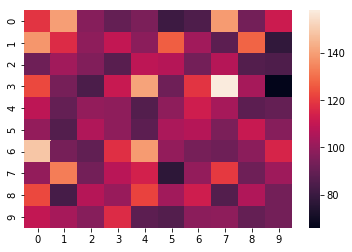

imdb_score


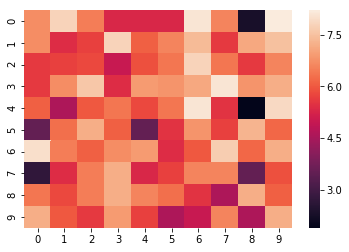

language


,0,1,2,3,4,5,6,7,8,9
0,English,English,English,Italian,English,English,English,English,English,Spanish
1,English,English,English,Hebrew,English,English,English,English,English,Spanish
2,English,English,English,English,English,English,English,English,English,Spanish
3,English,English,English,English,English,English,English,English,English,Spanish
4,English,English,English,Portuguese,English,English,English,English,English,English
5,English,English,English,English,English,English,English,English,French,English
6,English,English,English,English,English,English,English,English,English,Spanish
7,English,English,English,English,English,English,English,English,English,English
8,English,English,English,English,English,English,English,English,English,English
9,English,English,English,English,English,English,English,English,English,English


movie_facebook_likes


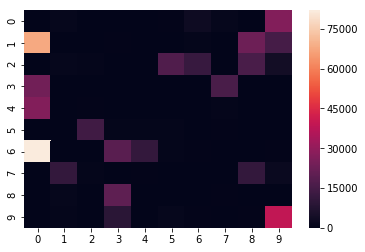

movie_title


,0,1,2,3,4,5,6,7,8,9
0,X-Men Origins: Wolverine,Maurice,Drop Dead Gorgeous,The Adventures of Pinocchio,Peeples,Spy Hard,High Noon,Ransom,Epic Movie,Pan's Labyrinth
1,The Wolverine,Boomerang,The Reaping,Indignation,Next Friday,Lethal Weapon 4,She Wore a Yellow Ribbon,Runner Runner,The Longest Ride,[Rec]
2,Fantastic 4: Rise of the Silver Surfer,Zipper,Hits,The Californians,Poetic Justice,Predators,Blazing Saddles,10th & Wolf,Beastly,[Rec] 2
3,Green Lantern,Mooz-Lum,Waiting for Guffman,The Young Messiah,Sunshine State,Bloodsport,Boom Town,There Will Be Blood,Copying Beethoven,Timecrimes
4,I Am Number Four,Rockaway,The Cry of the Owl,Gabriela,Undercover Brother,Ninja Assassin,The Man Who Shot Liberty Valance,Beverly Hills Cop III,Disaster Movie,Shrek
5,The Omega Code,Abandoned,Gremlins,Not Easily Broken,Dance Flick,Beauty Shop,Young Guns,All About the Benjamins,L'auberge espagnole,Princess Kaiulani
6,X-Men: Days of Future Past,Madison,Gentlemen Broncos,The Best of Me,Get on Up,Man of the House,American Outlaws,Sorcerer,Step Up 2: The Streets,Tango
7,Dragonball: Evolution,Blackhat,The Good Girl,Black Water Transit,"Welcome Home, Roscoe Jenkins",The Work and the Story,The Work and the Glory II: American Zion,The Immigrant,Fifty Shades of Black,There Be Dragons
8,Kate & Leopold,Zambezia,Big Miracle,It's Kind of a Funny Story,Think Like a Man,An Everlasting Piece,Shalako,Corky Romano,Half Nelson,Shrek the Third
9,Star Trek VI: The Undiscovered Country,Winnie Mandela,New in Town,A Good Year,Deuce Bigalow: Male Gigolo,The Virginity Hit,The Legend of the Lone Ranger,Shooting Fish,My Boss's Daughter,Brave


num_critic_for_reviews


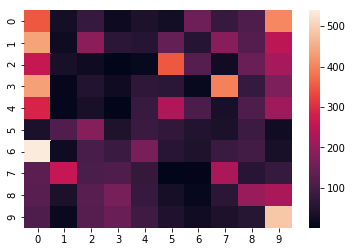

num_user_for_reviews


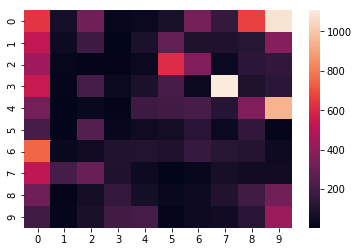

num_voted_users


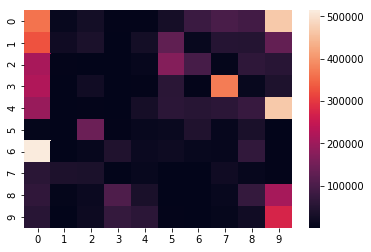

title_year


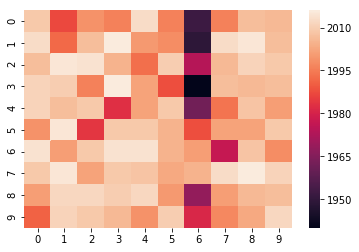

In [422]:
for df, feat in feat_dfs : 
    print(feat)
    if df.dtypes[0] == 'object' :
        display(df)
    else :
        plt.figure()
        sns.heatmap(df)
        plt.show()

About what we've just seen :
- Without saying that's it's a main criteria, the algorithm seems to recommend colored movies even for B&W movies
- As most of the movies in the database are US movies, we won't be foolish enough to say that country is a criteria or not for our tool, even if the last test movie from Spain gets a lot of Spanish recommendation. Same goes for language
- The director's name does not seem to be a factor of recommendation
- Heatmap of the duration is most likely evenly distributed, not a main feature then, same conclusion about IMDB score
- movie facebook likes are mostly 0. The feature might deserve not to be taken into account
- num_critic_for_reviews / num_user_for_reviews / num_voted_users / title year : Those shows similar colorsets column-wise, meaning that they might have been taken into account by the algorithm

Then the other features (genres, keywords and actors)

In [423]:
# Select features
features = [[x for x in res_df.columns if x.startswith('actor')]]
features.append([x for x in res_df.columns if x.startswith('genre')])
features.append([x for x in res_df.columns if x.startswith('kw')])

In [427]:
# Gather features in dataframes
feat_others_dfs = []
for feats in features :
    maha_df = res_df.iloc[100:,:].copy()
    maha_df.index = maha_df.index.droplevel()
    feat_df = maha_df.loc[:,feats].apply(lambda x: ','.join(x), axis=1)
    test_df = pd.DataFrame(index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
    for i in range(0,10) :
        test_df.iloc[:,i] = feat_df.iloc[i*10:(i+1)*10].values
    feat_others_dfs.append([test_df, feats])

In [428]:
# Transform values in count of common values to the reference movie
other_dfs = []
for df_other in feat_others_dfs :
    temp_df = pd.DataFrame(np.zeros((10,10)), index=[0,1,2,3,4,5,6,7,8,9], columns=[0,1,2,3,4,5,6,7,8,9])
    for i in range(0,10) :
        tp_df = df_other[0][i]
        for j in range(0,10) :
            values = tp_df.iloc[j].split(",")
            value_count = 0
            temp_df.iloc[j,i]
            for value in values :
                if (value != '0') and (value in tp_df.iloc[0].split(",")) :
                    value_count += 1
                    temp_df.iloc[j,i] = value_count
                elif value == '0' :
                    pass
    temp_df = temp_df.astype(int)
    
    other_dfs.append([temp_df, df_other[1]])

['actor_1', 'actor_2', 'actor_3']


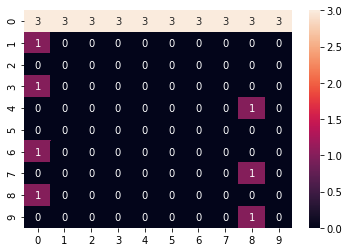

['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8']


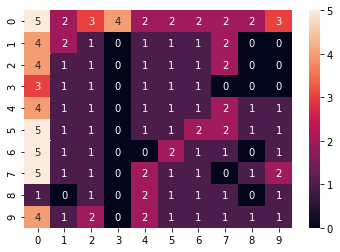

['kw_1', 'kw_2', 'kw_3', 'kw_4', 'kw_5']


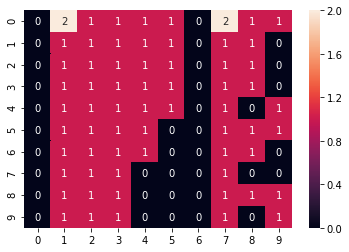

In [429]:
# Display the heatmaps
for df, feats in other_dfs : 
    print(feats)
    plt.figure()
    sns.heatmap(df, annot=True)
    plt.show()

About those 3 last features :
- Except for some test movies, the actors do not seem to be a criteria for the algorithm : almost zero actors in common between the recommendations and the reference
- Same conclusion goes for the genres, which are too few to be used properply
- On another hand the keywords seem to be well respected by the recommendations, which would indicate that keywords are one main criteria for the model

# 7) Conclusion

We've seen how different the recommendations can be based on the distance used in the algorithm, even if we've trained our second model (Mahalanobis) with only 150 components ! Which might explain why the results of this second algorithm seem less trustable (actually, using 2800 components is worse and the model does not make much sense)

For now we'll retain the model using euclidean distance which gives recommendations both diversified and close to the reference, which is pleasant for an opend-minded user

API on AWS :

In [ ]:
import urllib.request
movie_input = 52
URL = "http://movie-recommendation-flask-env.ampcxpgfpm.eu-west-2.elasticbeanstalk.com/recommend/maha/" + str(movie_input)
contents = urllib.request.urlopen(URL.read().decode('utf8')
print(contents)